# Final Project
### Introduction to Computational Medicine: Imaging 
### Group: 6

In [1]:
# import statements
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

## Part 1: Computing patient "bar codes"

First we load our dataset. For our project, we have selected Alzheimer's Disease, so we will be using the ADNI dataset.

In [2]:
# load ADNI dataset into a pandas dataframe
working_directory = "C:/Users/lizan/Desktop/Classes/ICM Imaging/ICM_ImagingFinalProject_Group6/"
dataset = "ADNI_ICM_random200.xlsx"
path = working_directory + dataset
ADNI_dataset = pd.read_excel(path)

# look at our dataset format
ADNI_dataset.head()

,'Subject_ID','Gender','Age','Diagnosis','ACR_R','AGWM_R','AG_R','ALIC_R','Amyg_R','AnteriorBasalForebrain_R',...,'TempSul_L','Thalamus_L','dorsalWM_ACC_L','dorsal_ACC_L','rostralWM_ACC_L','rostral_ACC_L','subcallosalWM_ACC_L','subcallosal_ACC_L','subgenualWM_ACC_L','subgenual_ACC_L'
0,'Subject_1','M',69.6712,'AD/MCI',14005,2932,10758,2073,1725,363,...,1349,5452,1424,10839,12,2082,95,369,226,1828
1,'Subject_2','F',85.3836,'AD/MCI',8811,2115,9418,2317,1590,276,...,1368,4578,1187,9102,5,1782,38,342,128,1438
2,'Subject_3','F',86.2904,'NORMAL',11982,2634,11015,2589,1803,299,...,1337,5987,1601,9902,92,1956,39,472,127,1644
3,'Subject_4','M',73.9342,'NORMAL',11919,3688,11322,2058,1868,217,...,1187,5005,1705,12301,12,1724,97,329,133,1485
4,'Subject_5','M',79.9918,'AD/MCI',10588,3010,11657,2161,1275,232,...,2131,5239,1517,11344,45,1823,28,312,90,1758


Next we will clean up the dataset. For this project, we are only using the subject ID, diagnosis, and structures within the chosen ROI. Since we chose the limbic system as our ROI, the structures we will be examining are the amygdala, fimbria, hippocampus, and mammillary bodies. 

In [3]:
# get relevant columns
structure_list = ["Amyg_L", "Amyg_R", 
                  "Fimbria_L", "Fimbria_R", 
                  "Hippo_L", "Hippo_R", 
                  "Mammillary_L", "Mammillary_R"]
pt_info = ["Subject_ID", "Diagnosis"]
relevant_columns = pt_info + structure_list

# remove all ' symbols from dataset  
ADNI_dataset.columns = ADNI_dataset.columns.str.replace('[\']', '', regex=True)
ADNI_dataset = ADNI_dataset.replace('[\']', '', regex=True)

# make new cleaned dataframe with only relevant columns
ADNI_dataset_cleaned = ADNI_dataset[relevant_columns]

# make subject_id only the number of the subject for clarity
ADNI_dataset_cleaned = ADNI_dataset_cleaned.replace({'Subject_':''}, regex=True)
ADNI_dataset_cleaned['Subject_ID'] = ADNI_dataset_cleaned['Subject_ID'].astype(int)

# change string in diagnosis to binary
ADNI_dataset_final = ADNI_dataset_cleaned.replace({'AD/MCI': 1, 'NORMAL': 0}, regex=True)

ADNI_dataset_final.head()

,Subject_ID,Diagnosis,Amyg_L,Amyg_R,Fimbria_L,Fimbria_R,Hippo_L,Hippo_R,Mammillary_L,Mammillary_R
0,1,1,1379,1725,0,8,2776,3041,98,74
1,2,1,1489,1590,0,0,2241,2685,45,50
2,3,0,1697,1803,0,5,3995,3875,101,101
3,4,0,1515,1868,40,4,3826,3684,118,97
4,5,1,1131,1275,0,0,2870,2549,98,75


Now we create a dataframe containing the volume means and standard deviations for the healthy subjects.

In [4]:
# subset all the healthy patients
ADNI_healthy = ADNI_dataset_final.loc[ADNI_dataset_final['Diagnosis'] == 0]

# create a dataframe for means and std dev of each structure
ADNI_describe = ADNI_healthy.iloc[:,2:].describe().iloc[1:3,:]
ADNI_describe.head()

,Amyg_L,Amyg_R,Fimbria_L,Fimbria_R,Hippo_L,Hippo_R,Mammillary_L,Mammillary_R
mean,1614.968750,1877.546875,7.687500,15.562500,3481.984375,3573.609375,93.421875,79.593750
std,330.041891,438.832323,8.581773,11.180872,549.324217,686.001148,15.983925,13.558479


Define a function that calculates the zscore for a column using mean and stddev from another dataframe

In [5]:
# Function to calculate zscores for a column of values
# Parameters: 
#    mean:    double
#    std:     double 
#    values:  list(doubles)
# Returns:
#    zscores: list(doubles)

def calculate_zscore(mean, std, values):
    zscore = [(x - mean)/std for x in values]
    return zscore

Create a dataframe containing zscores corresponding to each patient

In [6]:
# Create empty dataframe with column names
ADNI_zscores = pd.DataFrame(columns = ADNI_describe.columns)
ADNI_zscores.head()

,Amyg_L,Amyg_R,Fimbria_L,Fimbria_R,Hippo_L,Hippo_R,Mammillary_L,Mammillary_R


In [7]:
# Loop through to add zscores
for i in range(8):
    mean = ADNI_describe.iloc[0, i]
    std = ADNI_describe.iloc[1, i]
    ADNI_zscores.iloc[:,i] = calculate_zscore(mean, std, ADNI_dataset_final.iloc[:,i+2])

ADNI_zscores.head()

,Amyg_L,Amyg_R,Fimbria_L,Fimbria_R,Hippo_L,Hippo_R,Mammillary_L,Mammillary_R
0,-0.714966,-0.347620,-0.895794,-0.676378,-1.285187,-0.776397,0.286421,-0.412565
1,-0.381675,-0.655255,-0.895794,-1.391886,-2.259111,-1.295347,-3.029411,-2.182675
2,0.248548,-0.169876,-0.895794,-0.944694,0.933903,0.439344,0.474109,1.578809
3,-0.302897,-0.021755,3.765248,-1.034132,0.626252,0.160919,1.537678,1.283791
4,-1.466386,-1.373069,-0.895794,-1.391886,-1.114068,-1.493597,0.286421,-0.338810


In [8]:
# append subject ids to our dataset
ADNI_zscores = pd.concat([ADNI_dataset_final.iloc[:,0:1], ADNI_zscores], axis=1)
ADNI_zscores.head()

,Subject_ID,Amyg_L,Amyg_R,Fimbria_L,Fimbria_R,Hippo_L,Hippo_R,Mammillary_L,Mammillary_R
0,1,-0.714966,-0.347620,-0.895794,-0.676378,-1.285187,-0.776397,0.286421,-0.412565
1,2,-0.381675,-0.655255,-0.895794,-1.391886,-2.259111,-1.295347,-3.029411,-2.182675
2,3,0.248548,-0.169876,-0.895794,-0.944694,0.933903,0.439344,0.474109,1.578809
3,4,-0.302897,-0.021755,3.765248,-1.034132,0.626252,0.160919,1.537678,1.283791
4,5,-1.466386,-1.373069,-0.895794,-1.391886,-1.114068,-1.493597,0.286421,-0.338810


In [9]:
# reshape dataset so it can be plotted 
ADNI_zscores_melt = ADNI_zscores.melt(id_vars=["Subject_ID"], 
                                    var_name="Structure", 
                                    value_name="zscore")
ADNI_zscores_pivot = ADNI_zscores_melt.pivot("Subject_ID", "Structure", "zscore")
ADNI_zscores_pivot.head()

Structure,Amyg_L,Amyg_R,Fimbria_L,Fimbria_R,Hippo_L,Hippo_R,Mammillary_L,Mammillary_R
Subject_ID,,,,,,,,
1,-0.714966,-0.347620,-0.895794,-0.676378,-1.285187,-0.776397,0.286421,-0.412565
2,-0.381675,-0.655255,-0.895794,-1.391886,-2.259111,-1.295347,-3.029411,-2.182675
3,0.248548,-0.169876,-0.895794,-0.944694,0.933903,0.439344,0.474109,1.578809
4,-0.302897,-0.021755,3.765248,-1.034132,0.626252,0.160919,1.537678,1.283791
5,-1.466386,-1.373069,-0.895794,-1.391886,-1.114068,-1.493597,0.286421,-0.338810


In [10]:
# save data
filename = "zscores_data.xlsx"
path = working_directory + filename
ADNI_zscores.to_excel(path)

## Part 2: Comparing structure volumes between the "control" and "disease" groups

We will perform an independent t-test

In [11]:
# Create empty dataframe with column and row names
#row_names = ['statistic', 'pvalue']
ADNI_stattest = pd.DataFrame(columns = ADNI_describe.columns)

# Loop through to add statistic and p-value
for i in range(8):
    # temporary dataframe that contains diagnosis and current structure columns
    temp_df = ADNI_dataset_final.iloc[:, [1, i+2]]
    # compute t-value (statistic)
    statistic = stats.ttest_ind(temp_df.loc[temp_df['Diagnosis']==0].iloc[:,1],
                                temp_df.loc[temp_df['Diagnosis']==1].iloc[:,1], 
                               trim=0.2).statistic
    # compute pvalue 
    pvalue = stats.ttest_ind(temp_df.loc[temp_df['Diagnosis']==0].iloc[:,1],
                             temp_df.loc[temp_df['Diagnosis']==1].iloc[:,1],
                            trim=0.2).pvalue
    # add value to 
    ADNI_stattest.iloc[:,i] = [statistic, pvalue]

ADNI_stattest = ADNI_stattest.rename(index={0: "statistic", 1: "pvalue"})
ADNI_stattest.head()

,Amyg_L,Amyg_R,Fimbria_L,Fimbria_R,Hippo_L,Hippo_R,Mammillary_L,Mammillary_R
statistic,4.096477,4.779405,5.610636e+00,5.520348e+00,2.502499,2.709683,0.481021,-0.044098
pvalue,0.000077,0.000005,1.317161e-07,1.987485e-07,0.013678,0.007721,0.631377,0.964899


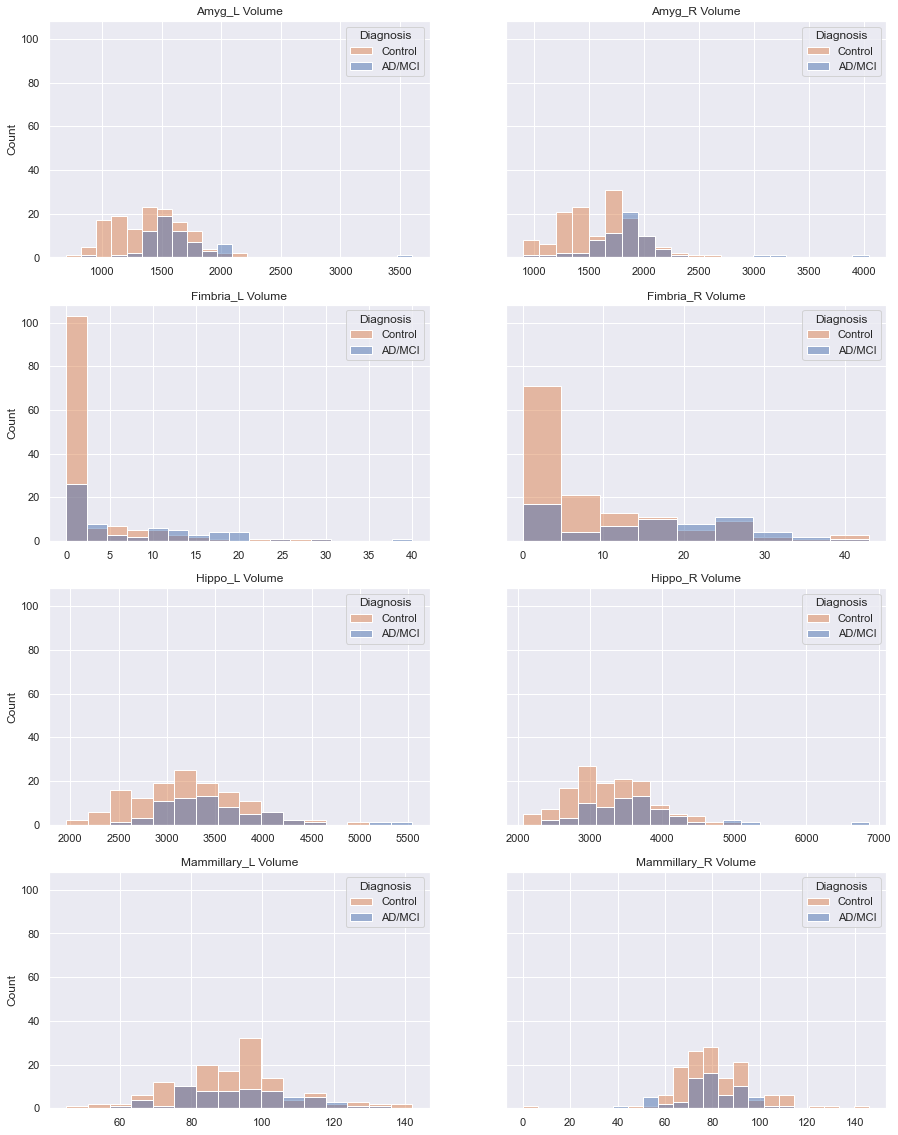

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(15,20), sharey=True)
 
for i in range(4):
    for j in range(2):
        col_count = 2*i + j
        sns.histplot(ax=axes[i,j], 
                     x=ADNI_dataset_final.iloc[:,col_count+2], 
                     hue=ADNI_dataset_final.Diagnosis)
        axes[i,j].legend(("Control", "AD/MCI"), title="Diagnosis")
        axes[i,j].set_xlabel(None)
        title = list(ADNI_dataset_final.columns.values)[col_count+2] + " Volume"
        axes[i,j].set_title(title)        

## Part 3 Creating Patient Barcode from MNI Dataset

Made a different file with just Type 1 Level 5 data, called MNI_T1L5.txt

In [18]:
# load ADNI dataset into a pandas dataframe
working_directory = "C:/Users/lizan/Desktop/Classes/ICM Imaging/ICM_ImagingFinalProject_Group6/"
dataset = "MNI_T1L5.xlsx"
path = working_directory + dataset
MNI_dataset = pd.read_excel(path)

# look at our dataset format
MNI_dataset

,Object,SFG_L,SFG_R,SFG_PFC_L,SFG_PFC_R,SFG_pole_L,SFG_pole_R,MFG_L,MFG_R,MFG_DPFC_L,...,OcciptSul_L,OcciptSul_R,TempSul_L,TempSul_R,Caudate_tail_L,Fimbria_L,Caudate_tail_R,Fimbria_R,Chroid_LVetc_L,Chroid_LVetc_R
0,Volume_mm3,10865.0000,9377.0000,8723.0000,10435.0000,1486.0000,3352.0000,9551.0000,7801.0000,9159.0000,...,4631.0000,3952.0000,3586.0000,2751.0000,489.0000,47.0000,618.0000,30.0000,195.0000,247.0000
1,Min,66.0000,48.0000,72.0000,70.0000,94.0000,82.0000,67.0000,70.0000,70.0000,...,21.0000,25.0000,0.0000,25.0000,146.0000,154.0000,128.0000,198.0000,178.0000,133.0000
2,Max,350.0000,340.0000,334.0000,336.0000,324.0000,342.0000,341.0000,360.0000,340.0000,...,229.0000,217.0000,183.0000,210.0000,381.0000,375.0000,431.0000,361.0000,303.0000,312.0000
3,Mean,204.0818,209.7685,201.2536,202.0519,202.9623,204.6915,201.2232,203.1217,205.6208,...,107.8616,109.4223,111.6447,112.9357,242.1677,296.4255,272.4207,284.9667,246.1026,231.3279
4,Std,43.8511,45.2967,46.5051,48.5460,44.8070,51.6780,46.9823,45.2418,49.1202,...,34.2005,34.0725,26.9749,34.2695,42.8046,43.5542,49.2386,42.1770,29.6451,32.8492


In [60]:
structure_list = ["Amyg_L", "Amyg_R", 
                  "Fimbria_L", "Fimbria_R", 
                  "Hippo_L", "Hippo_R", 
                  "Mammillary_L", "Mammillary_R"]

# make new cleaned dataframe with only relevant columns
MNI_dataset_cleaned = MNI_dataset[structure_list].iloc[0,:]
MNI_dataset_cleaned

Amyg_L          2001.0
Amyg_R          2130.0
Fimbria_L         47.0
Fimbria_R         30.0
Hippo_L         4789.0
Hippo_R         5026.0
Mammillary_L     174.0
Mammillary_R     145.0
Name: 0, dtype: float64

In [66]:
MNI_zscores = pd.DataFrame(columns = MNI_dataset[structure_list].columns)
MNI_zscores.head()

,Amyg_L,Amyg_R,Fimbria_L,Fimbria_R,Hippo_L,Hippo_R,Mammillary_L,Mammillary_R


In [67]:
# Loop through to add zscores
zscores = []
for i in range(8):
    mean = ADNI_describe.iloc[0, i]
    std = ADNI_describe.iloc[1, i]
    
    x = MNI_dataset_cleaned[i]
    zscore = (x - mean)/std 
    
    zscores.append(zscore)
        
MNI_zscores.loc[len(MNI_zscores)] = zscores
MNI_zscores

,Amyg_L,Amyg_R,Fimbria_L,Fimbria_R,Hippo_L,Hippo_R,Mammillary_L,Mammillary_R
0,1.169643,0.575284,4.58093,1.291268,2.379316,2.117184,5.041198,4.824011


In [68]:
# save data
filename = "MNI_zscores_data.xlsx"
path = working_directory + filename
MNI_zscores.to_excel(path)